# Link Predictor

In [1]:
from imports import *
from linkpred import *
from dataset import *

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.style as style 
style.use('seaborn-paper')
%matplotlib inline

fontsize = 12
plt.rcParams.update({
    'font.size': fontsize, 
    'axes.labelsize': fontsize, 
    'legend.fontsize': fontsize,
    'xtick.labelsize': fontsize,
    'ytick.labelsize': fontsize,
    'axes.titlesize': fontsize
                    })

/home/gavin/anaconda3/envs/pygeo/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
## set random seeds
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

In [3]:
print(torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device =', device)

1.5.1
device = cuda


## Load the Dataset

In [4]:
node_attributes = pd.read_csv('data/NDSSL data/raw/node_attributes.csv')
node_attributes.head(5)

,person_id,household_id,age,gender,worker,relationship,household_income,household_size,zipcode,household_vehicles,household_workers
0,2509159,2201175,42,1,1,1,13,3,97201,3,2
1,2509160,2201175,43,2,1,1,13,3,97201,3,2
2,2509161,2201175,17,1,2,2,13,3,97201,3,2
3,2509162,2201176,41,1,1,1,11,2,97201,3,1
4,2509163,2201176,11,1,2,2,11,2,97201,3,1


In [5]:
## remove old processed files
import os, shutil
if os.path.exists('data/NDSSL data/processed'):
    shutil.rmtree('data/NDSSL data/processed')

dataset = load_dataset(dataset_name='NDSSL')
data = dataset[0]
dataset.process()

Processing...
{'x': None, 'edge_index': tensor([[      0,       0,       1,  ..., 1486224, 1378614, 1556530],
        [      1,       2,       2,  ..., 1601329, 1601329, 1601329]]), 'edge_attr': None, 'y': None, 'pos': None, 'norm': None, 'face': None, 'edge_weight': tensor([10.9161, 12.7494, 12.5828,  ...,  0.0497,  0.1667,  0.1667])}
Done!
{'x': None, 'edge_index': tensor([[      0,       0,       1,  ..., 1486224, 1378614, 1556530],
        [      1,       2,       2,  ..., 1601329, 1601329, 1601329]]), 'edge_attr': None, 'y': None, 'pos': None, 'norm': None, 'face': None, 'edge_weight': tensor([10.9161, 12.7494, 12.5828,  ...,  0.0497,  0.1667,  0.1667])}


Perform the train/test split:

In [6]:
data = train_test_split_big(data, val_ratio=0.5, test_ratio=0.0001)

print('number of train edges: %i' %data.train_pos_edge_index.shape[1])
print('number of train edges: %i' %data.val_pos_edge_index.shape[1])
print('number of train edges: %i' %data.test_pos_edge_index.shape[1])

number of train edges: 19388850
number of train edges: 19570466
number of train edges: 3936


In [7]:
data_columns = ['age', 'gender', 'worker', 'relationship', 'household_income', 'household_size', 'zipcode', 'household_vehicles', 'household_workers']
data.x = dataframe2onehot(node_attributes[data_columns], node_attributes)
data.x.shape

torch.Size([1601330, 143])

In [8]:
train_data = Data(x=data.x, edge_index=data.train_pos_edge_index, y=data.y)
row, col = train_data.edge_index
train_data.edge_attr = 1. / degree(col, train_data.num_nodes)[col]  # Norm by in-degree.

In [9]:
val_data = Data(x=data.x, edge_index=data.val_pos_edge_index, y=data.y)
row, col = val_data.edge_index
val_data.edge_attr = 1. / degree(col, val_data.num_nodes)[col]  # Norm by in-degree.

In [10]:
test_data = Data(x=data.x, edge_index=data.test_pos_edge_index, y=data.y)
row, col = test_data.edge_index
test_data.edge_attr = 1. / degree(col, test_data.num_nodes)[col]  # Norm by in-degree.

In [11]:
walk_length = 30
batch_size = 1000
num_steps = 10
sample_coverage = 20

In [12]:
train_loader = GraphSAINTRandomWalkSampler(train_data, batch_size=batch_size, walk_length=walk_length,
                                     num_steps=num_steps, sample_coverage=sample_coverage,
                                     save_dir=None)

Compute GraphSAINT normalization: : 37091443it [00:38, 975916.50it/s]                            


In [13]:
val_loader = GraphSAINTRandomWalkSampler(val_data, batch_size=batch_size, walk_length=walk_length,
                                     num_steps=num_steps, sample_coverage=sample_coverage,
                                     save_dir=None)

Compute GraphSAINT normalization: : 36043436it [00:34, 1039014.43it/s]                            


test_loader = GraphSAINTRandomWalkSampler(test_data, batch_size=batch_size, walk_length=walk_length,
                                     num_steps=num_steps, sample_coverage=sample_coverage,
                                     save_dir=None)

## Link Predictor Model

In [14]:
model = Net(num_node_features=train_data.x.shape[1], hidden_channels=256, embed_dim=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [15]:
def train():
    model.train()
    model.set_aggr('mean')

    total_loss = total_examples = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.edge_attr) #batch.edge_norm * batch.edge_attr
        loss = model.recon_loss(out, batch.edge_index)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_examples += batch.num_edges
    return total_loss/total_examples


@torch.no_grad()
def evaluator(loader):
    model.eval()
    model.set_aggr('mean')
    
    y_target = torch.empty(0)
    y_pred = torch.empty(0)
    total_loss = total_examples = 0
    for batch in loader:
        batch = batch.to(device)
        
        out = model(batch.x, batch.edge_index, batch.edge_attr)
        total_loss += model.recon_loss(out, batch.edge_index).item()
        total_examples += batch.num_edges
        
        test_results = model.test(out, batch.edge_index, negative_sampling(batch.edge_index, out.size(0)))
        y_target = torch.cat((y_target, test_results[0]), 0)
        y_pred = torch.cat((y_pred, test_results[1]), 0)
        
    y_target = y_target.numpy()
    y_pred = y_pred.numpy()
    
    return total_loss/total_examples, y_target, y_pred

In [16]:
n_epochs = 2000
n_save = 100

results = {
    'train_loss':[],
    'val_loss':[],
    'val_auc':[],
    'val_ap':[]
          }

for epoch in range(1, n_epochs+1):
    train_loss = train()
    
    val_loss, y_target, y_pred = evaluator(val_loader)
    val_auc = roc_auc_score(y_target, y_pred)
    val_ap = average_precision_score(y_target, y_pred)
    
    results['train_loss'].append(train_loss)
    results['val_loss'].append(val_loss)
    results['val_auc'].append(val_auc)
    results['val_ap'].append(val_ap)
    
    if (epoch % n_save) == 0:
        torch.save(model.state_dict(), 'weights/link_predictor_epoch_' + str(epoch))
    
    print('Epoch: %i||Train Loss: %.3f||Val Loss: %.3f||Val AUC: %.3f||Val AP: %.3f' %(epoch, train_loss, val_loss, val_auc, val_ap))

Epoch: 1||Train Loss: 1.891||Val Loss: 1.784||Val AUC: 0.528||Val AP: 0.524
Epoch: 2||Train Loss: 1.816||Val Loss: 1.767||Val AUC: 0.590||Val AP: 0.566
Epoch: 3||Train Loss: 1.803||Val Loss: 1.762||Val AUC: 0.626||Val AP: 0.590
Epoch: 4||Train Loss: 1.796||Val Loss: 1.758||Val AUC: 0.628||Val AP: 0.593
Epoch: 5||Train Loss: 1.788||Val Loss: 1.749||Val AUC: 0.631||Val AP: 0.593
Epoch: 6||Train Loss: 1.781||Val Loss: 1.747||Val AUC: 0.641||Val AP: 0.605
Epoch: 7||Train Loss: 1.774||Val Loss: 1.737||Val AUC: 0.644||Val AP: 0.606
Epoch: 8||Train Loss: 1.768||Val Loss: 1.734||Val AUC: 0.646||Val AP: 0.609
Epoch: 9||Train Loss: 1.761||Val Loss: 1.732||Val AUC: 0.652||Val AP: 0.617
Epoch: 10||Train Loss: 1.754||Val Loss: 1.720||Val AUC: 0.656||Val AP: 0.619
Epoch: 11||Train Loss: 1.747||Val Loss: 1.720||Val AUC: 0.662||Val AP: 0.626
Epoch: 12||Train Loss: 1.739||Val Loss: 1.710||Val AUC: 0.669||Val AP: 0.633
Epoch: 13||Train Loss: 1.733||Val Loss: 1.702||Val AUC: 0.675||Val AP: 0.637
Epoch: 1

Epoch: 108||Train Loss: 1.190||Val Loss: 1.236||Val AUC: 0.872||Val AP: 0.858
Epoch: 109||Train Loss: 1.189||Val Loss: 1.218||Val AUC: 0.871||Val AP: 0.857
Epoch: 110||Train Loss: 1.183||Val Loss: 1.201||Val AUC: 0.875||Val AP: 0.863
Epoch: 111||Train Loss: 1.180||Val Loss: 1.219||Val AUC: 0.872||Val AP: 0.859
Epoch: 112||Train Loss: 1.173||Val Loss: 1.209||Val AUC: 0.873||Val AP: 0.862
Epoch: 113||Train Loss: 1.172||Val Loss: 1.221||Val AUC: 0.873||Val AP: 0.863
Epoch: 114||Train Loss: 1.168||Val Loss: 1.209||Val AUC: 0.874||Val AP: 0.860
Epoch: 115||Train Loss: 1.164||Val Loss: 1.196||Val AUC: 0.876||Val AP: 0.866
Epoch: 116||Train Loss: 1.161||Val Loss: 1.189||Val AUC: 0.878||Val AP: 0.867
Epoch: 117||Train Loss: 1.158||Val Loss: 1.191||Val AUC: 0.878||Val AP: 0.867
Epoch: 118||Train Loss: 1.151||Val Loss: 1.206||Val AUC: 0.877||Val AP: 0.867
Epoch: 119||Train Loss: 1.150||Val Loss: 1.189||Val AUC: 0.879||Val AP: 0.868
Epoch: 120||Train Loss: 1.144||Val Loss: 1.182||Val AUC: 0.881||

Epoch: 214||Train Loss: 0.868||Val Loss: 0.918||Val AUC: 0.923||Val AP: 0.918
Epoch: 215||Train Loss: 0.869||Val Loss: 0.920||Val AUC: 0.924||Val AP: 0.919
Epoch: 216||Train Loss: 0.864||Val Loss: 0.921||Val AUC: 0.923||Val AP: 0.919
Epoch: 217||Train Loss: 0.866||Val Loss: 0.945||Val AUC: 0.921||Val AP: 0.917
Epoch: 218||Train Loss: 0.861||Val Loss: 0.907||Val AUC: 0.923||Val AP: 0.919
Epoch: 219||Train Loss: 0.861||Val Loss: 0.909||Val AUC: 0.925||Val AP: 0.920
Epoch: 220||Train Loss: 0.856||Val Loss: 0.901||Val AUC: 0.925||Val AP: 0.921
Epoch: 221||Train Loss: 0.853||Val Loss: 0.911||Val AUC: 0.925||Val AP: 0.921
Epoch: 222||Train Loss: 0.851||Val Loss: 0.909||Val AUC: 0.925||Val AP: 0.922
Epoch: 223||Train Loss: 0.851||Val Loss: 0.897||Val AUC: 0.928||Val AP: 0.923
Epoch: 224||Train Loss: 0.850||Val Loss: 0.911||Val AUC: 0.926||Val AP: 0.921
Epoch: 225||Train Loss: 0.845||Val Loss: 0.901||Val AUC: 0.927||Val AP: 0.923
Epoch: 226||Train Loss: 0.842||Val Loss: 0.895||Val AUC: 0.926||

Epoch: 320||Train Loss: 0.681||Val Loss: 0.735||Val AUC: 0.948||Val AP: 0.946
Epoch: 321||Train Loss: 0.675||Val Loss: 0.728||Val AUC: 0.948||Val AP: 0.946
Epoch: 322||Train Loss: 0.676||Val Loss: 0.727||Val AUC: 0.949||Val AP: 0.947
Epoch: 323||Train Loss: 0.671||Val Loss: 0.724||Val AUC: 0.950||Val AP: 0.947
Epoch: 324||Train Loss: 0.670||Val Loss: 0.723||Val AUC: 0.950||Val AP: 0.948
Epoch: 325||Train Loss: 0.667||Val Loss: 0.723||Val AUC: 0.951||Val AP: 0.949
Epoch: 326||Train Loss: 0.670||Val Loss: 0.718||Val AUC: 0.950||Val AP: 0.948
Epoch: 327||Train Loss: 0.668||Val Loss: 0.733||Val AUC: 0.949||Val AP: 0.948
Epoch: 328||Train Loss: 0.665||Val Loss: 0.715||Val AUC: 0.950||Val AP: 0.949
Epoch: 329||Train Loss: 0.664||Val Loss: 0.716||Val AUC: 0.952||Val AP: 0.950
Epoch: 330||Train Loss: 0.661||Val Loss: 0.716||Val AUC: 0.951||Val AP: 0.949
Epoch: 331||Train Loss: 0.660||Val Loss: 0.709||Val AUC: 0.951||Val AP: 0.949
Epoch: 332||Train Loss: 0.660||Val Loss: 0.706||Val AUC: 0.951||

Epoch: 426||Train Loss: 0.546||Val Loss: 0.591||Val AUC: 0.966||Val AP: 0.965
Epoch: 427||Train Loss: 0.545||Val Loss: 0.602||Val AUC: 0.964||Val AP: 0.963
Epoch: 428||Train Loss: 0.543||Val Loss: 0.584||Val AUC: 0.966||Val AP: 0.965
Epoch: 429||Train Loss: 0.544||Val Loss: 0.592||Val AUC: 0.966||Val AP: 0.964
Epoch: 430||Train Loss: 0.542||Val Loss: 0.588||Val AUC: 0.965||Val AP: 0.964
Epoch: 431||Train Loss: 0.540||Val Loss: 0.588||Val AUC: 0.966||Val AP: 0.965
Epoch: 432||Train Loss: 0.540||Val Loss: 0.589||Val AUC: 0.965||Val AP: 0.964
Epoch: 433||Train Loss: 0.538||Val Loss: 0.592||Val AUC: 0.964||Val AP: 0.963
Epoch: 434||Train Loss: 0.536||Val Loss: 0.583||Val AUC: 0.965||Val AP: 0.964
Epoch: 435||Train Loss: 0.538||Val Loss: 0.579||Val AUC: 0.966||Val AP: 0.965
Epoch: 436||Train Loss: 0.535||Val Loss: 0.584||Val AUC: 0.966||Val AP: 0.965
Epoch: 437||Train Loss: 0.533||Val Loss: 0.587||Val AUC: 0.966||Val AP: 0.965
Epoch: 438||Train Loss: 0.532||Val Loss: 0.577||Val AUC: 0.967||

Epoch: 532||Train Loss: 0.450||Val Loss: 0.494||Val AUC: 0.976||Val AP: 0.975
Epoch: 533||Train Loss: 0.448||Val Loss: 0.495||Val AUC: 0.975||Val AP: 0.974
Epoch: 534||Train Loss: 0.448||Val Loss: 0.493||Val AUC: 0.975||Val AP: 0.974
Epoch: 535||Train Loss: 0.447||Val Loss: 0.486||Val AUC: 0.975||Val AP: 0.974
Epoch: 536||Train Loss: 0.446||Val Loss: 0.487||Val AUC: 0.975||Val AP: 0.975
Epoch: 537||Train Loss: 0.446||Val Loss: 0.494||Val AUC: 0.976||Val AP: 0.975
Epoch: 538||Train Loss: 0.444||Val Loss: 0.491||Val AUC: 0.976||Val AP: 0.974
Epoch: 539||Train Loss: 0.442||Val Loss: 0.491||Val AUC: 0.976||Val AP: 0.975
Epoch: 540||Train Loss: 0.443||Val Loss: 0.493||Val AUC: 0.976||Val AP: 0.975
Epoch: 541||Train Loss: 0.442||Val Loss: 0.488||Val AUC: 0.976||Val AP: 0.975
Epoch: 542||Train Loss: 0.440||Val Loss: 0.490||Val AUC: 0.976||Val AP: 0.975
Epoch: 543||Train Loss: 0.440||Val Loss: 0.483||Val AUC: 0.976||Val AP: 0.976
Epoch: 544||Train Loss: 0.439||Val Loss: 0.478||Val AUC: 0.976||

Epoch: 638||Train Loss: 0.380||Val Loss: 0.423||Val AUC: 0.982||Val AP: 0.981
Epoch: 639||Train Loss: 0.380||Val Loss: 0.421||Val AUC: 0.982||Val AP: 0.982
Epoch: 640||Train Loss: 0.378||Val Loss: 0.426||Val AUC: 0.981||Val AP: 0.981
Epoch: 641||Train Loss: 0.377||Val Loss: 0.423||Val AUC: 0.982||Val AP: 0.981
Epoch: 642||Train Loss: 0.376||Val Loss: 0.415||Val AUC: 0.982||Val AP: 0.981
Epoch: 643||Train Loss: 0.373||Val Loss: 0.420||Val AUC: 0.982||Val AP: 0.982
Epoch: 644||Train Loss: 0.376||Val Loss: 0.411||Val AUC: 0.982||Val AP: 0.982
Epoch: 645||Train Loss: 0.375||Val Loss: 0.414||Val AUC: 0.982||Val AP: 0.981
Epoch: 646||Train Loss: 0.376||Val Loss: 0.411||Val AUC: 0.982||Val AP: 0.982
Epoch: 647||Train Loss: 0.372||Val Loss: 0.410||Val AUC: 0.982||Val AP: 0.982
Epoch: 648||Train Loss: 0.372||Val Loss: 0.419||Val AUC: 0.982||Val AP: 0.981
Epoch: 649||Train Loss: 0.373||Val Loss: 0.415||Val AUC: 0.983||Val AP: 0.982
Epoch: 650||Train Loss: 0.373||Val Loss: 0.414||Val AUC: 0.983||

Epoch: 744||Train Loss: 0.324||Val Loss: 0.363||Val AUC: 0.986||Val AP: 0.985
Epoch: 745||Train Loss: 0.326||Val Loss: 0.364||Val AUC: 0.986||Val AP: 0.986
Epoch: 746||Train Loss: 0.323||Val Loss: 0.358||Val AUC: 0.986||Val AP: 0.986
Epoch: 747||Train Loss: 0.324||Val Loss: 0.360||Val AUC: 0.986||Val AP: 0.986
Epoch: 748||Train Loss: 0.324||Val Loss: 0.350||Val AUC: 0.986||Val AP: 0.986
Epoch: 749||Train Loss: 0.322||Val Loss: 0.353||Val AUC: 0.986||Val AP: 0.986
Epoch: 750||Train Loss: 0.323||Val Loss: 0.361||Val AUC: 0.986||Val AP: 0.986
Epoch: 751||Train Loss: 0.322||Val Loss: 0.359||Val AUC: 0.986||Val AP: 0.986
Epoch: 752||Train Loss: 0.323||Val Loss: 0.364||Val AUC: 0.986||Val AP: 0.986
Epoch: 753||Train Loss: 0.321||Val Loss: 0.354||Val AUC: 0.987||Val AP: 0.986
Epoch: 754||Train Loss: 0.321||Val Loss: 0.354||Val AUC: 0.986||Val AP: 0.986
Epoch: 755||Train Loss: 0.324||Val Loss: 0.354||Val AUC: 0.986||Val AP: 0.986
Epoch: 756||Train Loss: 0.321||Val Loss: 0.356||Val AUC: 0.986||

Epoch: 850||Train Loss: 0.284||Val Loss: 0.318||Val AUC: 0.989||Val AP: 0.989
Epoch: 851||Train Loss: 0.282||Val Loss: 0.310||Val AUC: 0.989||Val AP: 0.989
Epoch: 852||Train Loss: 0.284||Val Loss: 0.319||Val AUC: 0.989||Val AP: 0.988
Epoch: 853||Train Loss: 0.284||Val Loss: 0.315||Val AUC: 0.989||Val AP: 0.989
Epoch: 854||Train Loss: 0.282||Val Loss: 0.315||Val AUC: 0.989||Val AP: 0.989
Epoch: 855||Train Loss: 0.281||Val Loss: 0.308||Val AUC: 0.989||Val AP: 0.989
Epoch: 856||Train Loss: 0.279||Val Loss: 0.312||Val AUC: 0.989||Val AP: 0.989
Epoch: 857||Train Loss: 0.281||Val Loss: 0.322||Val AUC: 0.989||Val AP: 0.989
Epoch: 858||Train Loss: 0.282||Val Loss: 0.309||Val AUC: 0.989||Val AP: 0.989
Epoch: 859||Train Loss: 0.281||Val Loss: 0.309||Val AUC: 0.990||Val AP: 0.989
Epoch: 860||Train Loss: 0.281||Val Loss: 0.312||Val AUC: 0.989||Val AP: 0.989
Epoch: 861||Train Loss: 0.279||Val Loss: 0.314||Val AUC: 0.989||Val AP: 0.989
Epoch: 862||Train Loss: 0.279||Val Loss: 0.316||Val AUC: 0.989||

Epoch: 956||Train Loss: 0.250||Val Loss: 0.279||Val AUC: 0.991||Val AP: 0.991
Epoch: 957||Train Loss: 0.251||Val Loss: 0.286||Val AUC: 0.991||Val AP: 0.991
Epoch: 958||Train Loss: 0.250||Val Loss: 0.275||Val AUC: 0.992||Val AP: 0.991
Epoch: 959||Train Loss: 0.249||Val Loss: 0.280||Val AUC: 0.991||Val AP: 0.991
Epoch: 960||Train Loss: 0.249||Val Loss: 0.285||Val AUC: 0.991||Val AP: 0.991
Epoch: 961||Train Loss: 0.248||Val Loss: 0.278||Val AUC: 0.991||Val AP: 0.991
Epoch: 962||Train Loss: 0.249||Val Loss: 0.285||Val AUC: 0.992||Val AP: 0.991
Epoch: 963||Train Loss: 0.250||Val Loss: 0.276||Val AUC: 0.991||Val AP: 0.991
Epoch: 964||Train Loss: 0.249||Val Loss: 0.286||Val AUC: 0.992||Val AP: 0.992
Epoch: 965||Train Loss: 0.247||Val Loss: 0.271||Val AUC: 0.992||Val AP: 0.991
Epoch: 966||Train Loss: 0.248||Val Loss: 0.279||Val AUC: 0.991||Val AP: 0.991
Epoch: 967||Train Loss: 0.250||Val Loss: 0.276||Val AUC: 0.992||Val AP: 0.991
Epoch: 968||Train Loss: 0.246||Val Loss: 0.276||Val AUC: 0.992||

Epoch: 1061||Train Loss: 0.222||Val Loss: 0.248||Val AUC: 0.993||Val AP: 0.993
Epoch: 1062||Train Loss: 0.223||Val Loss: 0.248||Val AUC: 0.993||Val AP: 0.993
Epoch: 1063||Train Loss: 0.224||Val Loss: 0.248||Val AUC: 0.993||Val AP: 0.993
Epoch: 1064||Train Loss: 0.222||Val Loss: 0.250||Val AUC: 0.993||Val AP: 0.993
Epoch: 1065||Train Loss: 0.222||Val Loss: 0.247||Val AUC: 0.993||Val AP: 0.993
Epoch: 1066||Train Loss: 0.222||Val Loss: 0.255||Val AUC: 0.993||Val AP: 0.993
Epoch: 1067||Train Loss: 0.223||Val Loss: 0.244||Val AUC: 0.993||Val AP: 0.993
Epoch: 1068||Train Loss: 0.222||Val Loss: 0.249||Val AUC: 0.993||Val AP: 0.993
Epoch: 1069||Train Loss: 0.223||Val Loss: 0.245||Val AUC: 0.993||Val AP: 0.993
Epoch: 1070||Train Loss: 0.223||Val Loss: 0.244||Val AUC: 0.993||Val AP: 0.993
Epoch: 1071||Train Loss: 0.222||Val Loss: 0.244||Val AUC: 0.993||Val AP: 0.993
Epoch: 1072||Train Loss: 0.222||Val Loss: 0.238||Val AUC: 0.993||Val AP: 0.993
Epoch: 1073||Train Loss: 0.223||Val Loss: 0.245||Val

Epoch: 1165||Train Loss: 0.202||Val Loss: 0.228||Val AUC: 0.994||Val AP: 0.994
Epoch: 1166||Train Loss: 0.201||Val Loss: 0.223||Val AUC: 0.995||Val AP: 0.994
Epoch: 1167||Train Loss: 0.205||Val Loss: 0.222||Val AUC: 0.994||Val AP: 0.994
Epoch: 1168||Train Loss: 0.203||Val Loss: 0.222||Val AUC: 0.994||Val AP: 0.994
Epoch: 1169||Train Loss: 0.204||Val Loss: 0.222||Val AUC: 0.994||Val AP: 0.994
Epoch: 1170||Train Loss: 0.201||Val Loss: 0.221||Val AUC: 0.994||Val AP: 0.994
Epoch: 1171||Train Loss: 0.204||Val Loss: 0.222||Val AUC: 0.994||Val AP: 0.994
Epoch: 1172||Train Loss: 0.203||Val Loss: 0.223||Val AUC: 0.994||Val AP: 0.994
Epoch: 1173||Train Loss: 0.202||Val Loss: 0.224||Val AUC: 0.994||Val AP: 0.994
Epoch: 1174||Train Loss: 0.201||Val Loss: 0.226||Val AUC: 0.994||Val AP: 0.994
Epoch: 1175||Train Loss: 0.201||Val Loss: 0.228||Val AUC: 0.994||Val AP: 0.994
Epoch: 1176||Train Loss: 0.201||Val Loss: 0.224||Val AUC: 0.994||Val AP: 0.994
Epoch: 1177||Train Loss: 0.200||Val Loss: 0.225||Val

Epoch: 1269||Train Loss: 0.186||Val Loss: 0.204||Val AUC: 0.995||Val AP: 0.995
Epoch: 1270||Train Loss: 0.186||Val Loss: 0.204||Val AUC: 0.995||Val AP: 0.995
Epoch: 1271||Train Loss: 0.185||Val Loss: 0.209||Val AUC: 0.995||Val AP: 0.995
Epoch: 1272||Train Loss: 0.187||Val Loss: 0.204||Val AUC: 0.995||Val AP: 0.995
Epoch: 1273||Train Loss: 0.187||Val Loss: 0.202||Val AUC: 0.995||Val AP: 0.995
Epoch: 1274||Train Loss: 0.184||Val Loss: 0.203||Val AUC: 0.995||Val AP: 0.995
Epoch: 1275||Train Loss: 0.184||Val Loss: 0.205||Val AUC: 0.995||Val AP: 0.995
Epoch: 1276||Train Loss: 0.185||Val Loss: 0.209||Val AUC: 0.995||Val AP: 0.995
Epoch: 1277||Train Loss: 0.184||Val Loss: 0.197||Val AUC: 0.995||Val AP: 0.995
Epoch: 1278||Train Loss: 0.185||Val Loss: 0.199||Val AUC: 0.995||Val AP: 0.995
Epoch: 1279||Train Loss: 0.183||Val Loss: 0.205||Val AUC: 0.995||Val AP: 0.995
Epoch: 1280||Train Loss: 0.186||Val Loss: 0.203||Val AUC: 0.995||Val AP: 0.995
Epoch: 1281||Train Loss: 0.184||Val Loss: 0.203||Val

Epoch: 1373||Train Loss: 0.173||Val Loss: 0.193||Val AUC: 0.996||Val AP: 0.996
Epoch: 1374||Train Loss: 0.173||Val Loss: 0.189||Val AUC: 0.996||Val AP: 0.996
Epoch: 1375||Train Loss: 0.170||Val Loss: 0.193||Val AUC: 0.996||Val AP: 0.996
Epoch: 1376||Train Loss: 0.172||Val Loss: 0.191||Val AUC: 0.996||Val AP: 0.996
Epoch: 1377||Train Loss: 0.174||Val Loss: 0.189||Val AUC: 0.996||Val AP: 0.996
Epoch: 1378||Train Loss: 0.173||Val Loss: 0.194||Val AUC: 0.996||Val AP: 0.996
Epoch: 1379||Train Loss: 0.173||Val Loss: 0.183||Val AUC: 0.996||Val AP: 0.996
Epoch: 1380||Train Loss: 0.170||Val Loss: 0.189||Val AUC: 0.996||Val AP: 0.996
Epoch: 1381||Train Loss: 0.170||Val Loss: 0.192||Val AUC: 0.996||Val AP: 0.996
Epoch: 1382||Train Loss: 0.171||Val Loss: 0.185||Val AUC: 0.996||Val AP: 0.996
Epoch: 1383||Train Loss: 0.171||Val Loss: 0.188||Val AUC: 0.996||Val AP: 0.996
Epoch: 1384||Train Loss: 0.169||Val Loss: 0.189||Val AUC: 0.996||Val AP: 0.996
Epoch: 1385||Train Loss: 0.171||Val Loss: 0.189||Val

Epoch: 1477||Train Loss: 0.160||Val Loss: 0.173||Val AUC: 0.996||Val AP: 0.996
Epoch: 1478||Train Loss: 0.162||Val Loss: 0.181||Val AUC: 0.996||Val AP: 0.996
Epoch: 1479||Train Loss: 0.160||Val Loss: 0.174||Val AUC: 0.996||Val AP: 0.996
Epoch: 1480||Train Loss: 0.159||Val Loss: 0.176||Val AUC: 0.996||Val AP: 0.996
Epoch: 1481||Train Loss: 0.161||Val Loss: 0.182||Val AUC: 0.996||Val AP: 0.996
Epoch: 1482||Train Loss: 0.161||Val Loss: 0.174||Val AUC: 0.996||Val AP: 0.996
Epoch: 1483||Train Loss: 0.160||Val Loss: 0.172||Val AUC: 0.996||Val AP: 0.996
Epoch: 1484||Train Loss: 0.160||Val Loss: 0.177||Val AUC: 0.996||Val AP: 0.996
Epoch: 1485||Train Loss: 0.159||Val Loss: 0.175||Val AUC: 0.996||Val AP: 0.996
Epoch: 1486||Train Loss: 0.160||Val Loss: 0.180||Val AUC: 0.996||Val AP: 0.996
Epoch: 1487||Train Loss: 0.160||Val Loss: 0.175||Val AUC: 0.997||Val AP: 0.996
Epoch: 1488||Train Loss: 0.160||Val Loss: 0.176||Val AUC: 0.996||Val AP: 0.996
Epoch: 1489||Train Loss: 0.159||Val Loss: 0.169||Val

Epoch: 1581||Train Loss: 0.152||Val Loss: 0.164||Val AUC: 0.997||Val AP: 0.997
Epoch: 1582||Train Loss: 0.150||Val Loss: 0.165||Val AUC: 0.997||Val AP: 0.997
Epoch: 1583||Train Loss: 0.152||Val Loss: 0.169||Val AUC: 0.997||Val AP: 0.997
Epoch: 1584||Train Loss: 0.151||Val Loss: 0.161||Val AUC: 0.997||Val AP: 0.997
Epoch: 1585||Train Loss: 0.151||Val Loss: 0.163||Val AUC: 0.997||Val AP: 0.997
Epoch: 1586||Train Loss: 0.151||Val Loss: 0.166||Val AUC: 0.997||Val AP: 0.997
Epoch: 1587||Train Loss: 0.151||Val Loss: 0.166||Val AUC: 0.997||Val AP: 0.997
Epoch: 1588||Train Loss: 0.151||Val Loss: 0.172||Val AUC: 0.997||Val AP: 0.997
Epoch: 1589||Train Loss: 0.151||Val Loss: 0.167||Val AUC: 0.997||Val AP: 0.997
Epoch: 1590||Train Loss: 0.150||Val Loss: 0.162||Val AUC: 0.997||Val AP: 0.997
Epoch: 1591||Train Loss: 0.150||Val Loss: 0.162||Val AUC: 0.997||Val AP: 0.997
Epoch: 1592||Train Loss: 0.149||Val Loss: 0.170||Val AUC: 0.997||Val AP: 0.997
Epoch: 1593||Train Loss: 0.150||Val Loss: 0.167||Val

Epoch: 1685||Train Loss: 0.143||Val Loss: 0.154||Val AUC: 0.997||Val AP: 0.997
Epoch: 1686||Train Loss: 0.144||Val Loss: 0.161||Val AUC: 0.997||Val AP: 0.997
Epoch: 1687||Train Loss: 0.144||Val Loss: 0.160||Val AUC: 0.997||Val AP: 0.997
Epoch: 1688||Train Loss: 0.143||Val Loss: 0.156||Val AUC: 0.997||Val AP: 0.997
Epoch: 1689||Train Loss: 0.142||Val Loss: 0.158||Val AUC: 0.997||Val AP: 0.997
Epoch: 1690||Train Loss: 0.143||Val Loss: 0.154||Val AUC: 0.997||Val AP: 0.997
Epoch: 1691||Train Loss: 0.142||Val Loss: 0.161||Val AUC: 0.997||Val AP: 0.997
Epoch: 1692||Train Loss: 0.142||Val Loss: 0.154||Val AUC: 0.997||Val AP: 0.997
Epoch: 1693||Train Loss: 0.142||Val Loss: 0.149||Val AUC: 0.997||Val AP: 0.997
Epoch: 1694||Train Loss: 0.142||Val Loss: 0.154||Val AUC: 0.997||Val AP: 0.997
Epoch: 1695||Train Loss: 0.142||Val Loss: 0.155||Val AUC: 0.997||Val AP: 0.997
Epoch: 1696||Train Loss: 0.143||Val Loss: 0.155||Val AUC: 0.997||Val AP: 0.997
Epoch: 1697||Train Loss: 0.142||Val Loss: 0.158||Val

Epoch: 1789||Train Loss: 0.136||Val Loss: 0.152||Val AUC: 0.997||Val AP: 0.997
Epoch: 1790||Train Loss: 0.137||Val Loss: 0.147||Val AUC: 0.997||Val AP: 0.997
Epoch: 1791||Train Loss: 0.138||Val Loss: 0.149||Val AUC: 0.997||Val AP: 0.997
Epoch: 1792||Train Loss: 0.137||Val Loss: 0.150||Val AUC: 0.997||Val AP: 0.997
Epoch: 1793||Train Loss: 0.137||Val Loss: 0.150||Val AUC: 0.997||Val AP: 0.997
Epoch: 1794||Train Loss: 0.136||Val Loss: 0.150||Val AUC: 0.997||Val AP: 0.997
Epoch: 1795||Train Loss: 0.136||Val Loss: 0.151||Val AUC: 0.997||Val AP: 0.997
Epoch: 1796||Train Loss: 0.137||Val Loss: 0.148||Val AUC: 0.997||Val AP: 0.997
Epoch: 1797||Train Loss: 0.137||Val Loss: 0.144||Val AUC: 0.997||Val AP: 0.997
Epoch: 1798||Train Loss: 0.135||Val Loss: 0.149||Val AUC: 0.998||Val AP: 0.997
Epoch: 1799||Train Loss: 0.136||Val Loss: 0.144||Val AUC: 0.997||Val AP: 0.997
Epoch: 1800||Train Loss: 0.135||Val Loss: 0.146||Val AUC: 0.997||Val AP: 0.997
Epoch: 1801||Train Loss: 0.137||Val Loss: 0.145||Val

Epoch: 1893||Train Loss: 0.131||Val Loss: 0.144||Val AUC: 0.998||Val AP: 0.998
Epoch: 1894||Train Loss: 0.129||Val Loss: 0.142||Val AUC: 0.998||Val AP: 0.998
Epoch: 1895||Train Loss: 0.130||Val Loss: 0.140||Val AUC: 0.998||Val AP: 0.998
Epoch: 1896||Train Loss: 0.129||Val Loss: 0.144||Val AUC: 0.998||Val AP: 0.998
Epoch: 1897||Train Loss: 0.130||Val Loss: 0.142||Val AUC: 0.998||Val AP: 0.998
Epoch: 1898||Train Loss: 0.129||Val Loss: 0.147||Val AUC: 0.998||Val AP: 0.998
Epoch: 1899||Train Loss: 0.131||Val Loss: 0.144||Val AUC: 0.997||Val AP: 0.997
Epoch: 1900||Train Loss: 0.129||Val Loss: 0.139||Val AUC: 0.998||Val AP: 0.998
Epoch: 1901||Train Loss: 0.130||Val Loss: 0.140||Val AUC: 0.998||Val AP: 0.998
Epoch: 1902||Train Loss: 0.129||Val Loss: 0.139||Val AUC: 0.998||Val AP: 0.998
Epoch: 1903||Train Loss: 0.128||Val Loss: 0.142||Val AUC: 0.998||Val AP: 0.998
Epoch: 1904||Train Loss: 0.131||Val Loss: 0.140||Val AUC: 0.998||Val AP: 0.998
Epoch: 1905||Train Loss: 0.130||Val Loss: 0.139||Val

Epoch: 1997||Train Loss: 0.125||Val Loss: 0.142||Val AUC: 0.998||Val AP: 0.998
Epoch: 1998||Train Loss: 0.125||Val Loss: 0.139||Val AUC: 0.998||Val AP: 0.998
Epoch: 1999||Train Loss: 0.126||Val Loss: 0.136||Val AUC: 0.998||Val AP: 0.998
Epoch: 2000||Train Loss: 0.125||Val Loss: 0.131||Val AUC: 0.998||Val AP: 0.998


## Analyze the Results

N.B. The train loss is the average throughout the entire epoch, whereas the test loss is computed after a single training epoch.

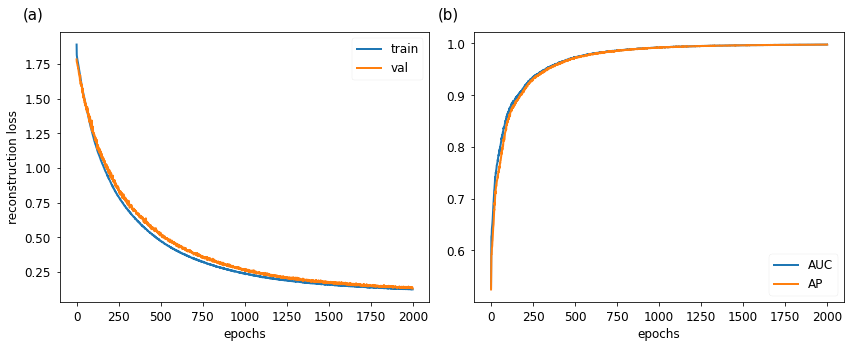

In [17]:
lw = 2
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes = axes.flatten()

axes[0].text(-0.1, 1.05, '(a)', transform=axes[0].transAxes, size=15)
axes[1].text(-0.1, 1.05, '(b)', transform=axes[1].transAxes, size=15)

axes[0].plot(results['train_loss'], label='train', linewidth=lw)
axes[0].plot(results['val_loss'], label='val', linewidth=lw)
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('reconstruction loss')
axes[0].legend()

axes[1].plot(results['val_auc'], label='AUC', linewidth=lw)
axes[1].plot(results['val_ap'], label='AP', linewidth=lw)
axes[1].set_xlabel('epochs')
axes[1].legend()

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig('figures/link_prediction_trainresults.pdf')
plt.show()

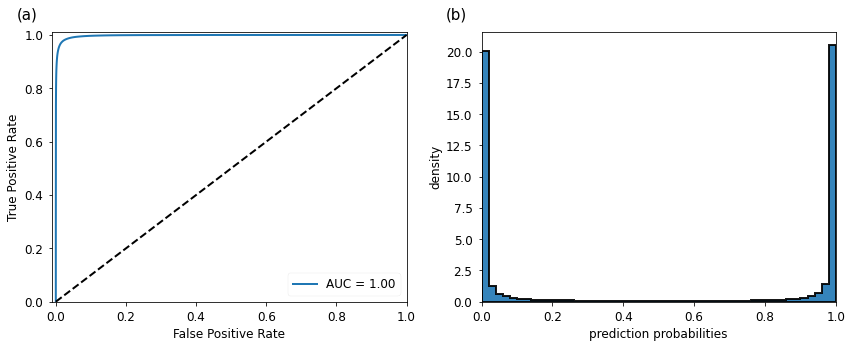

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes = axes.flatten()

axes[0].text(-0.1, 1.05, '(a)', transform=axes[0].transAxes, size=15)
axes[1].text(-0.1, 1.05, '(b)', transform=axes[1].transAxes, size=15)

fpr, tpr, thresholds = roc_curve(y_target, y_pred)
axes[0].plot(fpr, tpr, lw=lw, label='AUC = %0.2f' % results['val_auc'][-1])
axes[0].plot([0, 1], [0, 1], color='k', lw=lw, linestyle='--')
axes[0].set_xlim([-0.01, 1.0])
axes[0].set_ylim([0.0, 1.01])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].legend(loc="lower right")

kwargs = dict(histtype='stepfilled', alpha=0.9, density=True, bins=50, edgecolor='k', linewidth=lw)
axes[1].hist(y_pred, **kwargs)
axes[1].set_xlabel('prediction probabilities')
axes[1].set_ylabel('density')
axes[1].set_xlim([0,1])

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig('figures/link_prediction_testresults.pdf')
plt.show()

In [19]:
np.median(y_pred)

0.5926835

Use the validation set to pick the model with the lowest test loss and then load from that checkpoint:

In [20]:
best_epoch = np.argmin(np.asarray(results['val_loss']))
best_epoch = int(math.ceil(best_epoch / 100.0)) * 100
best_epoch

2000

### Evaluate on Test Set

In [21]:
model = Net(num_node_features=data.x.shape[1], hidden_channels=256, embed_dim=64).to(device)
model.load_state_dict(torch.load('weights/link_predictor_epoch_' + str(best_epoch)))
model.eval()
model.set_aggr('mean')

In [22]:
test_loss, y_target, y_pred = evaluator(test_loader)
test_auc = roc_auc_score(y_target, y_pred)
test_ap = average_precision_score(y_target, y_pred)
test_acc = np.mean(y_target == (y_pred > 0.5))
print('Test Loss: %.3f|Test ACC: %.2f||Test AUC: %.3f||Test AP: %.3f' %(test_loss, test_acc, test_auc, test_ap))

NameError: name 'test_loader' is not defined

In [ ]:
lw = 2
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes = axes.flatten()

axes[0].text(-0.1, 1.05, '(a)', transform=axes[0].transAxes, size=15)
axes[1].text(-0.1, 1.05, '(b)', transform=axes[1].transAxes, size=15)

fpr, tpr, thresholds = roc_curve(y_target, y_pred)
axes[0].plot(fpr, tpr, lw=lw, label='AUC = %0.2f' % test_auc)
axes[0].plot([0, 1], [0, 1], color='k', lw=lw, linestyle='--')
axes[0].set_xlim([-0.01, 1.0])
axes[0].set_ylim([0.0, 1.01])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].legend(loc="lower right")

kwargs = dict(histtype='stepfilled', alpha=0.9, density=True, bins=50, edgecolor='k', linewidth=lw)
axes[1].hist(y_pred, **kwargs)
axes[1].set_xlabel('prediction probabilities')
axes[1].set_ylabel('density')
axes[1].set_xlim([0,1])

fig.tight_layout()  # otherwise the right y-label is slightly clipped
#plt.savefig('figures/link_prediction_testresults.pdf')
plt.show()